In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Conv1D, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict
import xgboost as xgb
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

benchmark_dataframe=pd.DataFrame()

In [ ]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    random.seed(seed)
    np.random.seed(seed)

set_global_seed(42)

# Метрики

In [ ]:
def compute_metrics(
    outputs: np.array,
    labels:  np.array
) -> Dict[str, float]:

    metrics = {}

    y_pred = outputs
    y_true = labels

    # accuracy
    accuracy = accuracy_score(
        y_true=y_true,
        y_pred=y_pred,
    )

    # precision
    precision_micro = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="micro",
        zero_division=0,
    )
    precision_macro = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="macro",
        zero_division=0,
    )
    precision_weighted = precision_score(
        y_true=y_true,
        y_pred=y_pred,
        average="weighted",
        zero_division=0,
    )

    # recall
    recall_micro = recall_score(
        y_true=y_true,
        y_pred=y_pred,
        average="micro",
        zero_division=0,

    )
    recall_macro = recall_score(
        y_true=y_true,
        y_pred=y_pred,
        average="macro",
        zero_division=0,
    )
    recall_weighted = recall_score(
        y_true=y_true,
        y_pred=y_pred,
        average="weighted",
        zero_division=0,
    )

    # f1
    f1_micro = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="micro",
        zero_division=0,
    )
    f1_macro = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="macro",
        zero_division=0,
    )
    f1_weighted = f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average="weighted",
        zero_division=0,
    )

    metrics["accuracy"] = accuracy

    metrics["precision_micro"]    = precision_micro
    metrics["precision_macro"]    = precision_macro
    metrics["precision_weighted"] = precision_weighted

    metrics["recall_micro"]    = recall_micro
    metrics["recall_macro"]    = recall_macro
    metrics["recall_weighted"] = recall_weighted

    metrics["f1_micro"]    = f1_micro
    metrics["f1_macro"]    = f1_macro
    metrics["f1_weighted"] = f1_weighted

    return metrics

# Анализ данных

In [ ]:
df = pd.read_csv(r'vulnerability_dataset_FIN.csv')
df.head(10)

,code,CWE_ID,description,vulnerability_status
0,value = Lorg/apache/commons/collections4/funct...,NaN,NaN,0
1,accessFlags = 0x8,NaN,NaN,0
2,"name = ""PrototypeSerializationFactory""",NaN,NaN,0
3,value = {,NaN,NaN,0
4,"""<T::"",",NaN,NaN,0
5,"""Ljava/io/Serializable;"",",NaN,NaN,0
6,""">"",",NaN,NaN,0
7,"""Ljava/lang/Object;"",",NaN,NaN,0
8,"""Lorg/apache/commons/collections4/Factory<"",",NaN,NaN,0
9,"""TT;>;""",NaN,NaN,0


In [ ]:
classes_ = df['CWE_ID'].value_counts(normalize=True)
classes_

CWE_ID
CWE-502    0.371237
CWE-22     0.331104
CWE-601    0.229097
CWE-749    0.030100
CWE-921    0.015050
CWE-532    0.015050
CWE-79     0.003344
CWE-319    0.003344
CWE-89     0.001672
Name: proportion, dtype: float64

In [ ]:
minor_classes_ = list(classes_[classes_<0.04].index)
minor_classes_

['CWE-749', 'CWE-921', 'CWE-532', 'CWE-79', 'CWE-319', 'CWE-89']

In [ ]:
df.shape

(310542, 4)

In [ ]:
df.describe()

,vulnerability_status
count,310542.000000
mean,0.001926
std,0.043840
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
df['vulnerability_status'].value_counts(normalize=True)

vulnerability_status
0    0.998074
1    0.001926
Name: proportion, dtype: float64

# Векторизация (BOW, TF-IDF)

In [ ]:
def tfidf_vectorizer(x: List[str]):
    v = TfidfVectorizer()
    return v.fit_transform(x), v

In [ ]:
def bow_vectorizer(x: List[str]):
  v = CountVectorizer()
  return v.fit_transform(x), v

# Подготовка данных для бинарной классификации



In [ ]:
df_ = df.copy()
df.drop(columns=['CWE_ID', 'description'], inplace=True)
#df = df[df['vulnerability_status'].notna()]
df.head()

,code,vulnerability_status
0,value = Lorg/apache/commons/collections4/funct...,0
1,accessFlags = 0x8,0
2,"name = ""PrototypeSerializationFactory""",0
3,value = {,0
4,"""<T::"",",0


In [ ]:
df.describe()

,vulnerability_status
count,310542.000000
mean,0.001926
std,0.043840
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.code, df.vulnerability_status, stratify=df.vulnerability_status, test_size=0.3, shuffle=True)
y_train.value_counts()

vulnerability_status
0    216960
1       419
Name: count, dtype: int64

In [ ]:
X_train_vect, vector_ = bow_vectorizer(X_train)
X_test_vect = vector_.transform(X_test)

# Decision Tree (bin)

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train_vect, y_train)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test)

## Запись результатов

In [ ]:
name='DecisionTreeClassifier_binary'
model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299


# Random Forest (bin)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_vect, y_train)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test)

## Запись результатов

In [ ]:
name='RandomForestClassifier_binary'
model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228


# XGBoost (bin)

In [ ]:
params = {
    'objective':'binary:logistic',
    'num_class':1,
    'max_depth':4,
    'learning_rate':0.001,
    'n_estimators':1000,
    'num_rounds':1,
    'verbose':True,
    'device':'cuda'
}

model = xgb.XGBClassifier(**params)
setattr(model, 'verbosity', 2)

model.fit(X_train_vect, y_train)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:35:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:35:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


## Запись результатов

In [ ]:
name='XGBClassifier_binary'
model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105


# RNN (bin)

In [ ]:
X_train_vect_tf, vector_tf = tfidf_vectorizer(X_train)
X_test_vect_tf = vector_tf.transform(X_test)
X_train.apply(lambda x: len(x)).describe()

count    217379.000000
mean         49.534136
std         105.151877
min           1.000000
25%          17.000000
50%          23.000000
75%          79.000000
max       39958.000000
Name: code, dtype: float64

In [ ]:
MAX_LEN = int(X_train.apply(lambda x: len(x)).median())
print(MAX_LEN)

23


In [ ]:
optimizer = Adam(learning_rate=0.0001)

X_train_pad = pad_sequences(X_train_vect_tf.toarray(), maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_vect_tf.toarray(), maxlen=MAX_LEN)
X_train_pad.shape

(217379, 23)

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [ ]:
vocab_size = len(vector_tf.vocabulary_.items()) + 1
embedding_dim = 100
maxlen = len(X_train[0])

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history_rnn_bin = model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_data=(X_test_pad, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
1699/1699 [==============================] - 263s 152ms/step - loss: 0.0153 - accuracy: 0.9975 - val_loss: 0.0142 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 2/20
1699/1699 [==============================] - 203s 120ms/step - loss: 0.0141 - accuracy: 0.9981 - val_loss: 0.0140 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 3/20
1699/1699 [==============================] - 201s 118ms/step - loss: 0.0141 - accuracy: 0.9981 - val_loss: 0.0143 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 4/20
1699/1699 [==============================] - 203s 120ms/step - loss: 0.0141 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 5/20
1699/1699 [==============================] - 218s 128ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0140 - val_accuracy: 0.9981 - lr: 1.0000e-03
Epoch 6/20
1699/1699 [==============================] - 227s 134ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 1.0000e-03
Epoch 7/20
1699/1699 [====

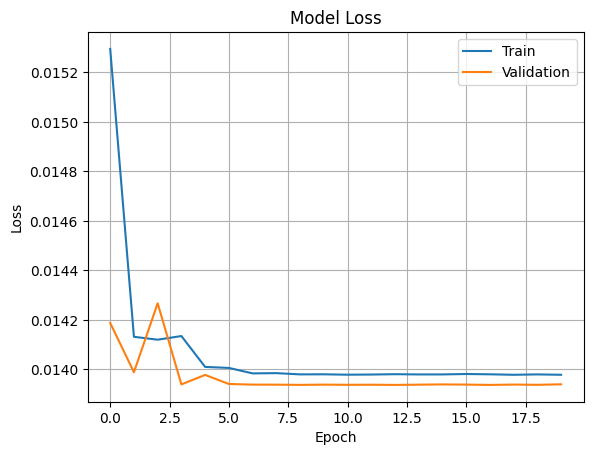

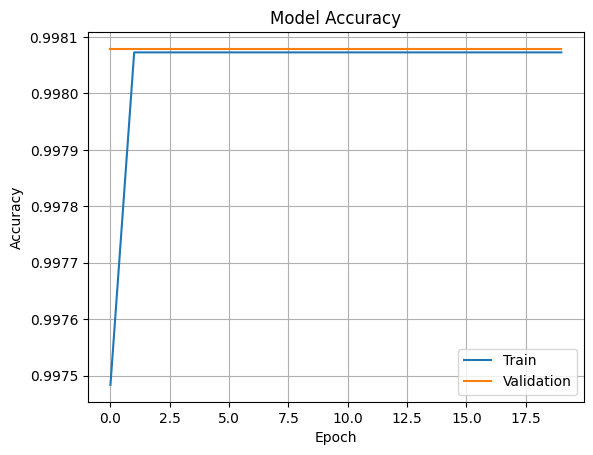

In [ ]:
plt.plot(history_rnn_bin.history['loss'])
plt.plot(history_rnn_bin.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

plt.plot(history_rnn_bin.history['accuracy'])
plt.plot(history_rnn_bin.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()

## Запись результатов

In [ ]:
name='BiLSTM_binary'

pedictions = model.predict(X_train_pad)
metrics_train = compute_metrics(outputs=np.where(pedictions>0.5, 1,0), labels=y_train.values)

pedictions = model.predict(X_test_pad)
metrics_test = compute_metrics(outputs=np.where(pedictions>0.5, 1,0), labels=y_test.values)

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

2912/2912 [==============================] - 25s 9ms/step


,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# CNN (bin)

In [ ]:
vocab_size = len(vector_tf.vocabulary_.items()) + 1
embedding_dim = 100
maxlen = len(X_train[0])

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
6794/6794 [==============================] - 218s 32ms/step - loss: 2.7049 - accuracy: 0.9962 - val_loss: 0.0155 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 2/20
6794/6794 [==============================] - 230s 34ms/step - loss: 0.8574 - accuracy: 0.9965 - val_loss: 1.4115 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 3/20
6794/6794 [==============================] - 216s 32ms/step - loss: 0.5130 - accuracy: 0.9969 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 4/20
6794/6794 [==============================] - 216s 32ms/step - loss: 0.0148 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 5/20
6794/6794 [==============================] - 219s 32ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0140 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 6/20
6794/6794 [==============================] - 213s 31ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 0.0020
Epoch 7/20
6794/6794 [==================

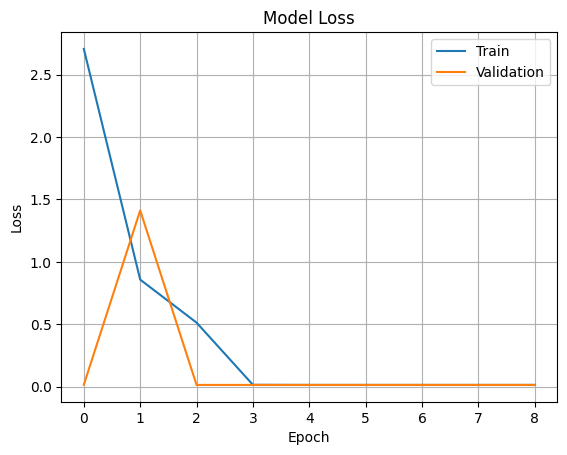

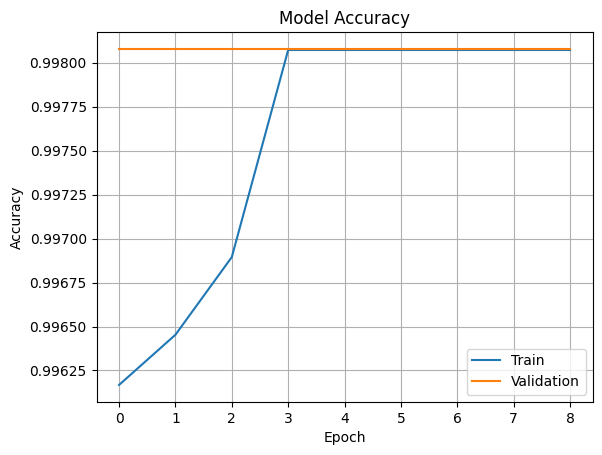

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()

## Запись результатов

In [ ]:
name='Embeddings_CNN_binary'

pedictions = model.predict(X_train_pad)
metrics_train = compute_metrics(outputs=np.where(pedictions>0.5, 1,0), labels=y_train.values)

pedictions = model.predict(X_test_pad)
metrics_test = compute_metrics(outputs=np.where(pedictions>0.5, 1,0), labels=y_test.values)

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

2912/2912 [==============================] - 11s 4ms/step


,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# Подготовка данных для мультиклассовой классификации

In [ ]:
df_cw = df_.copy()

df_cw.drop(columns=['description', 'vulnerability_status'], inplace=True)
df_cw['CWE_ID'] = df_cw['CWE_ID'].fillna('Not vulnerable')
df_cw['CWE_ID'] = df_cw['CWE_ID'].apply(lambda x: "minor_vulnerability" if x in minor_classes_ else x)

df_cw['CWE_ID'].isna().sum().any()

False

In [ ]:
labels_ = set(list(df_cw['CWE_ID'].values))
labels_dict = {v:k for k, v in enumerate(labels_)}
print(labels_dict)
df_cw['CW_label']  = df_cw['CWE_ID'].map(labels_dict)
#df_cw.head(10)

{'Not vulnerable': 0, 'CWE-22': 1, 'CWE-502': 2, 'minor_vulnerability': 3, 'CWE-601': 4}


In [ ]:
y_train_ = df_cw.loc[y_train.index, 'CW_label']
y_test_ = df_cw.loc[y_test.index, 'CW_label']

y_train_.value_counts()

CW_label
0    216960
2       156
1       136
4        93
3        34
Name: count, dtype: int64

# Decision Tree (mul)

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train_vect, y_train_)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train_)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test_)

## Запись результатов

In [ ]:
name='DecisionTreeClassifier_multiclass'

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')
benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# Random Forest (mul)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_vect, y_train_)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train_)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test_)

## Запись результатов

In [ ]:
name='RandomForestClassifier_multiclass'

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')
benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# XGBoost (mul)

In [ ]:
params = {
    #'objective':'multi:softprob',
    'objective':'binary:logistic',
    'num_class':1,
    'max_depth':4,
    'learning_rate':0.001,
    'n_estimators':1000,
    'num_rounds':1,
    'verbose':True,
    'device':'cuda'

}

model = xgb.XGBClassifier(**params)
setattr(model, 'verbosity', 2)

model.fit(X_train_vect, y_train)

pedictions = model.predict(X_train_vect)
metrics_train = compute_metrics(outputs=pedictions, labels=y_train_)

pedictions = model.predict(X_test_vect)
metrics_test = compute_metrics(outputs=pedictions, labels=y_test_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


## Запись результатов

In [ ]:
name='XGBClassifier_multiclass'

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')
benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# RNN (mul)

In [ ]:
vocab_size = len(vector_tf.vocabulary_.items()) + 1
embedding_dim = 100
maxlen = len(X_train[0])

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(len(set(list(y_train_))), activation='softmax'))


optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history_rnn_mul = model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_data=(X_test_pad, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
1699/1699 [==============================] - 201s 116ms/step - loss: 0.0170 - accuracy: 0.9975 - val_loss: 0.0140 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 2/20
1699/1699 [==============================] - 199s 117ms/step - loss: 0.0142 - accuracy: 0.9981 - val_loss: 0.0141 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 3/20
1699/1699 [==============================] - 201s 118ms/step - loss: 0.0142 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 0.0050
Epoch 4/20
1699/1699 [==============================] - 223s 131ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0142 - val_accuracy: 0.9981 - lr: 1.0000e-03
Epoch 5/20
1699/1699 [==============================] - 208s 122ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 1.0000e-03
Epoch 6/20
1699/1699 [==============================] - 201s 118ms/step - loss: 0.0140 - accuracy: 0.9981 - val_loss: 0.0139 - val_accuracy: 0.9981 - lr: 2.0000e-04
Epoch 7/20
1699/1699 [

## График

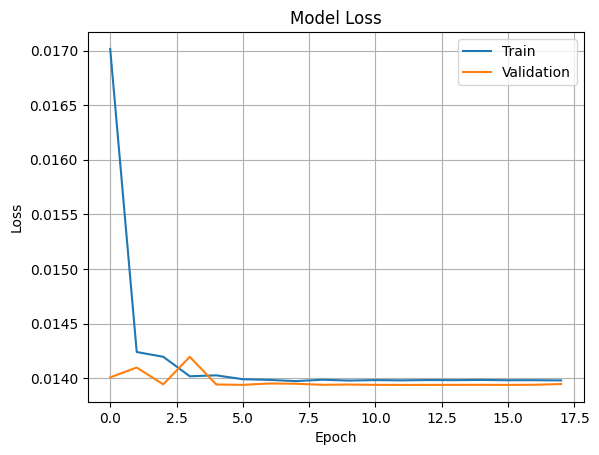

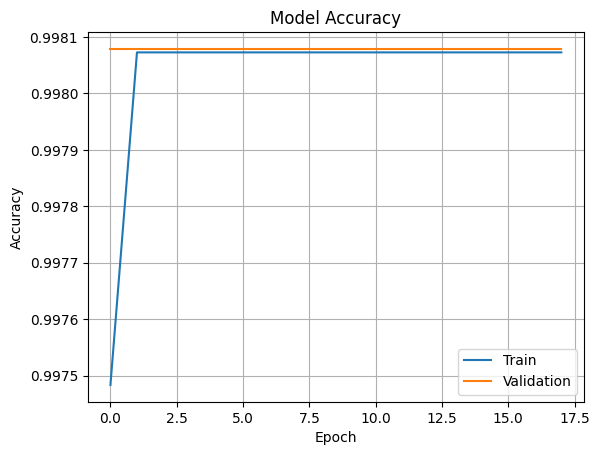

In [ ]:
plt.plot(history.history_rnn_mul['loss'])
plt.plot(history.history_rnn_mul['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

plt.plot(history.history_rnn_mul['accuracy'])
plt.plot(history.history_rnn_mul['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()

## Запись результатов

In [ ]:
name='BiLSTM_multiclass'

pedictions = model.predict(X_train_pad)
metrics_train = compute_metrics(outputs=pedictions.argmax(axis=1), labels=y_train.values)

pedictions = model.predict(X_test_pad)
metrics_test = compute_metrics(outputs=pedictions.argmax(axis=1), labels=y_test.values)

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])
benchmark_dataframe

2912/2912 [==============================] - 28s 10ms/step


,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


# CNN (mul)

In [ ]:
vocab_size = len(vector_tf.vocabulary_.items()) + 1
embedding_dim = 100
maxlen = len(X_train[0])

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_LEN))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(len(set(list(y_train_))), activation='softmax'))


optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history_cnn_mul = model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/20
6794/6794 [==============================] - 223s 33ms/step - loss: 3.1535 - accuracy: 0.9944 - val_loss: 0.4546 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 2/20
6794/6794 [==============================] - 219s 32ms/step - loss: 5.0283 - accuracy: 0.9950 - val_loss: 8.2784 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 3/20
6794/6794 [==============================] - 225s 33ms/step - loss: 6.1033 - accuracy: 0.9954 - val_loss: 13.1634 - val_accuracy: 0.9981 - lr: 0.0100
Epoch 4/20
6794/6794 [==============================] - 240s 35ms/step - loss: 3.1681 - accuracy: 0.9966 - val_loss: 1.4011 - val_accuracy: 0.9981 - lr: 0.0020
Epoch 5/20
6794/6794 [==============================] - 219s 32ms/step - loss: 0.6571 - accuracy: 0.9969 - val_loss: 0.4308 - val_accuracy: 0.9981 - lr: 0.0020
Epoch 6/20
6794/6794 [==============================] - 231s 34ms/step - loss: 0.5171 - accuracy: 0.9969 - val_loss: 0.0405 - val_accuracy: 0.9981 - lr: 0.0020
Epoch 7/20
6794/6794 [=================

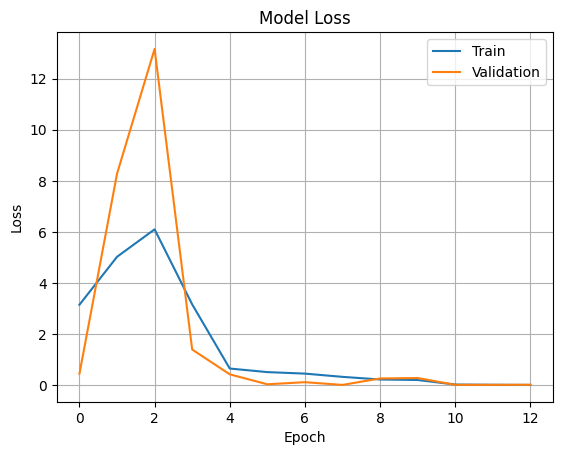

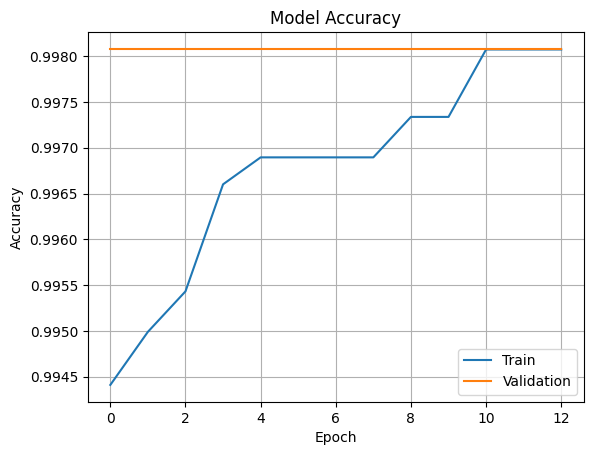

In [ ]:
plt.plot(history_cnn_mul.history['loss'])
plt.plot(history_cnn_mul.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

plt.plot(history_cnn_mul.history['accuracy'])
plt.plot(history_cnn_mul.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()

## Запись результатов

In [ ]:
name='CNN_multiclass'

pedictions = model.predict(X_train_pad)
metrics_train = compute_metrics(outputs=pedictions.argmax(axis=1), labels=y_train.values)

pedictions = model.predict(X_test_pad)
metrics_test = compute_metrics(outputs=pedictions.argmax(axis=1), labels=y_test.values)

model_dict = {'train': list(metrics_train.values()), 'test': list(metrics_test.values())}
colnames = ['name', 'train/test']
colnames.extend(list(metrics_train.keys()))

df__ = pd.DataFrame(model_dict).T
df__.reset_index(inplace=True)
df__['name'] = name
df__ = df__[['name', 'index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
df__.columns = colnames
df__.set_index('name')

benchmark_dataframe = pd.concat([benchmark_dataframe, df__])

2912/2912 [==============================] - 13s 4ms/step


## Таблица результатов

In [ ]:
benchmark_dataframe

,name,train/test,accuracy,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted,f1_micro,f1_macro,f1_weighted
0,DecisionTreeClassifier_binary,train,0.999531,0.999531,0.938127,0.999532,0.999531,0.940214,0.999531,0.999531,0.939168,0.999531
1,DecisionTreeClassifier_binary,test,0.999281,0.999281,0.891285,0.999325,0.999281,0.932730,0.999281,0.999281,0.910960,0.999299
0,RandomForestClassifier_binary,train,0.999531,0.999531,0.936360,0.999534,0.999531,0.942596,0.999531,0.999531,0.939456,0.999532
1,RandomForestClassifier_binary,test,0.999216,0.999216,0.889307,0.999242,0.999216,0.913182,0.999216,0.999216,0.900888,0.999228
0,XGBClassifier_binary,train,0.999158,0.999158,0.929562,0.999100,0.999158,0.836410,0.999158,0.999158,0.877299,0.999107
1,XGBClassifier_binary,test,0.999141,0.999141,0.913617,0.999090,0.999141,0.849022,0.999141,0.999141,0.878573,0.999105
0,BiLSTM_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,BiLSTM_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119
0,Embeddings_CNN_binary,train,0.998072,0.998072,0.499036,0.996149,0.998072,0.500000,0.998072,0.998072,0.499518,0.997110
1,Embeddings_CNN_binary,test,0.998079,0.998079,0.499039,0.996161,0.998079,0.500000,0.998079,0.998079,0.499519,0.997119


In [ ]:
from google.colab import files
benchmark_dataframe.to_csv("benchmark_dataframe_1.csv")
files.download('benchmark_dataframe_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>